In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
# Some utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import  image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from keras.applications.inception_v3  import InceptionV3
import matplotlib.pyplot as plt
import numpy as np

In [3]:
myTrainDir = r"C:\Users\agusa\OneDrive\Escritorio\Ing\IA\DataResos\Dataset"
target_sz = (128, 128)


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

train_generator = train_datagen.flow_from_directory(myTrainDir,
                                                 target_size=target_sz,
                                                 batch_size=20,
                                                 class_mode='categorical',                                                 
                                                 shuffle=False, 
                                                 seed=20,
                                                 subset="training" )
                                                
validation_generator = train_datagen.flow_from_directory(myTrainDir,
                                                 target_size=target_sz,
                                                 batch_size=20,
                                                 class_mode='categorical',                                                 
                                                 shuffle=False, 
                                                 seed=20,
                                                 subset="validation")   

xTrain=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
yTrain=np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
print(xTrain.shape)
print(yTrain.shape)

xTest=np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
yTest=np.concatenate([validation_generator.next()[1] for i in range(validation_generator.__len__())])
print(xTest.shape)
print(yTest.shape)

labels = list(train_generator.class_indices.keys())  
print(labels)

shuffler = np. random. permutation(len(yTrain))
xTrain = xTrain[shuffler]
yTrain = yTrain[shuffler]

shuffler = np. random. permutation(len(yTest))
xTest = xTest[shuffler]
yTest = yTest[shuffler]

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
(5121, 128, 128, 3)
(5121, 4)
(1279, 128, 128, 3)
(1279, 4)
['Enfermedad Leve', 'Enfermedad Moderada', 'Enfermedad Severa', 'Sano']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 1.]
Sano


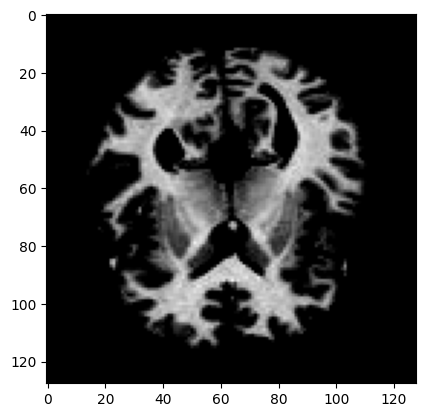

In [4]:
model = InceptionV3()
#model.summary()
n=6

plt.imshow(xTest[n])
print(yTest[n])
print(labels[np.argmax(yTest[n])])

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import  RMSprop, Adam, Adamax

num_class = 4  # Cantidad de clases a clasificar


base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(128,128,3))

# COMIENZO A AGREGAR DISTINTAS CAPAS
# NOTA: ESTO TAMBIEN SE PUEDE HACER MEDIATE UNA RED SECUENCIAL
x = base_model.output
# AGREGAMOS ALGUNAS CAPAS A LA RED BASE
x = GlobalAveragePooling2D(name="GAP2D_Al")(x)
x = Flatten(name="flatten")(x)
x = Dense(512,activation='relu', name="Dense1_Al")(x)
x = Dropout(0.5, name="Drop1_Al")(x)
x = Dense(512,activation='tanh', name="Dense2_Al")(x) 
x = Dropout(0.5, name="Drop2_Al")(x)
# FINALMENTE AGREGO UNA CAPA SOFTMAX CON 4 CLASES
preds = Dense(num_class, activation='softmax', name="Softmax1_Al")(x) 

# ARMO EL MODELO COMPLETO
model = Model(inputs=base_model.input, outputs=preds)


# Freeze four convolution blocks
for layer in model.layers[:311]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

model.summary()

0 input_2 False
1 conv2d_94 False
2 batch_normalization_94 False
3 activation_94 False
4 conv2d_95 False
5 batch_normalization_95 False
6 activation_95 False
7 conv2d_96 False
8 batch_normalization_96 False
9 activation_96 False
10 max_pooling2d_4 False
11 conv2d_97 False
12 batch_normalization_97 False
13 activation_97 False
14 conv2d_98 False
15 batch_normalization_98 False
16 activation_98 False
17 max_pooling2d_5 False
18 conv2d_102 False
19 batch_normalization_102 False
20 activation_102 False
21 conv2d_100 False
22 conv2d_103 False
23 batch_normalization_100 False
24 batch_normalization_103 False
25 activation_100 False
26 activation_103 False
27 average_pooling2d_9 False
28 conv2d_99 False
29 conv2d_101 False
30 conv2d_104 False
31 conv2d_105 False
32 batch_normalization_99 False
33 batch_normalization_101 False
34 batch_normalization_104 False
35 batch_normalization_105 False
36 activation_99 False
37 activation_101 False
38 activation_104 False
39 activation_105 False
40 mixed

In [6]:
# DEFINO LA CANTIDAD DE EPOCAS DE ENTRENAMIENTO
# ATENCION! N0 HAGO EARLY STOP
epochs = 60
# DEFINO LA TASA DE APRENDIZAJE
learning_rate = 0.001
# 00 - lr = 0.0005
# 01 - lr = 0.001

# DEFINO LA TASA DE CAIDA
# decay_rate = learning_rate / epochs
#decay_rate = 0.01
# 00 - decay = learning_rate / epochs
# 01 - decay = 0.01
# 02 - decay = 0.001

# DEFINO EL OPTIMIZADOR
# opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=decay_rate, amsgrad=False)
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=0.1, amsgrad=False)
#opt2 = Adamax( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.02)
# COMPILO EL MODELO - USO CATEGORICAL CROSSENTROPY COMO LOSS FUNCTION
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['categorical_accuracy'])

history = model.fit(x1, y1, epochs=2)

NameError: name 'x1' is not defined